### Procedure

Make smaller all_data_info.csv 
1. Read in the csv file into a dataframe using pandas
2. find all unique values for the artist field
3. pick 4 artists we will start out with
4. make new dataframe with just values of these artists
5. save this dataframe to csv file

Make smaller dataset
1. Search through the folders to see any matching files in the csv table
2. create subfolders for each class of interest
3. copy and paste those files into subfolders of smaller_dataset 

Create ImageGenerator
1. Crop the images to 224x224, create ImageGenerator with 50% flipping, and standarize the images (standard noramlize it)

Create the network
1. CNN
2. Pretrain network

In [53]:
import pandas as pd
import numpy as np
import os, shutil
import io
import random

In [57]:
#Random Seed
random.seed(1)

### 1) Create new csv file for a smaller dataset
Import the csv table containing artist info for each jpeg file (painting). Choose the top 5 artists with the most paintings in the dataset, and create new csv file with only selected artists.

In [47]:
#Import Data
df = pd.read_csv('all_data_info.csv')
df.head()

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg


In [58]:
#For initial classifier, only classify only 5 artists. Choose the artists with the most paintings available in dataset
artist_counts = df.artist.value_counts()
chosen_artists_counts = artist_counts[:5]
chosen_artists = chosen_artists_counts.index
print(chosen_artists_counts)

df_small = df[df['artist'].isin(chosen_artists)]
print(df_small.shape)

Pierre-Auguste Renoir    500
Albrecht Durer           500
Marc Chagall             500
Ivan Aivazovsky          500
Rembrandt                500
Name: artist, dtype: int64
(2500, 12)


In [60]:
#Save new csv file
df_small.to_csv('small_data_info.csv')

### 2) Create Smaller Dataset
Using the small table, search for paintings in the large folder and copy into smaller folder. Create test/train subfolders and subfolders for each class (artist)

In [269]:
#Directory for smaller dataset
base_dir = 'data_small'
os.mkdir(base_dir)

#Make test/train directories
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

#Make directories for each class
for artist in chosen_artists:
    train_class_subfolder = os.path.join(train_dir, artist)
    test_class_subfolder = os.path.join(test_dir, artist)
    os.mkdir(train_class_subfolder)
    os.mkdir(test_class_subfolder)

In [270]:
#80/20 split index
train_test_splits = round(df_small.artist.value_counts() *.8).astype('int')

In [271]:
#Copy the original images to smaller dataset
original_dataset = 'Data/train'

for row in range(df_small.shape[0]):
    fname = df_small['new_filename'].iloc[row]
    artist = df_small['artist'].iloc[row]
    
    #Once the index values hit 0, then we have found 80% of the paintings from that particular aritst for training, and should start fill up the test set
    train_test_splits[artist] = train_test_splits[artist] - 1
    src = os.path.join(original_dataset, fname)
    
    if(train_test_splits[artist] >= 0):
        dst = os.path.join(train_dir, artist)
    else:
        dst = os.path.join(test_dir, artist)
        
    if(os.path.exists(src)):
        shutil.copy(src, dst)

### 3) Create Generator to crop images
Sizes of image must be 224x224 for the neural network input. We do not want to resize entire image, rather we want to crop images so we can preserve artist style. We will create generator that takes in an ImageDataGenerator generator and crop image.

In [64]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Lets create functions for croppping images. Using: https://jkjung-avt.github.io/keras-image-cropping/. The crop_generator function will use "yield" to generated cropped images for the next batch in the ImageDataGenerator generator. The random_crop function will take in an image and return a randomly cropped image. The crop_generator function will also return a batch_y which is the label for the image. If ImageDataGenerator.flow_from_directory(class='categorical), then the batch_y for each data in batch, will be a 1 hot-encoding vector of classes

In [285]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

Lets test our crop_generator by plotting some random images from our directory using ImageDataGenerator, combined with our crop_generator. Lets make sure that the dimensions are 224x224

Found 1504 images belonging to 5 classes.
Shape is:  (224, 224, 3)
Shape is:  (224, 224, 3)
Shape is:  (224, 224, 3)


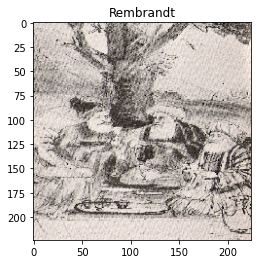

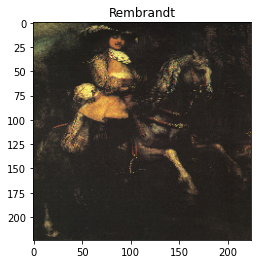

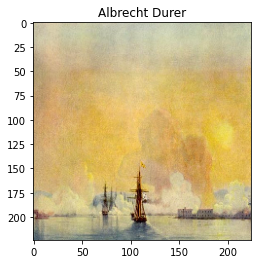

In [257]:
base_dir = 'data_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

#Create generator from directory, with cropping
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_batches = train_datagen.flow_from_directory(train_dir)
train_crops = crop_generator(train_batches, 224)

#Pandas index (indices of a series) to list
chosen_artist_list = chosen_artists.to_list()

#Show 3 random cropped images
i = 0
for batch, batch_y in train_crops:
    plt.figure(i)
    print('Shape is: ', batch[0].shape)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    #The batch_y[0] returns 1-hot class vector, and nonzero to extract index with '1'. np.nonzero gets tuple of lists for nonzer (tuple bcz one for each dimension of arr)
    idx = np.nonzero(batch_y[0])[0][0]
    plt.title(chosen_artist_list[idx])
    i += 1
    if i % 3 == 0:
        break;
plt.show()

Try the function random_crop for one image, and see that it crops randomly everytime

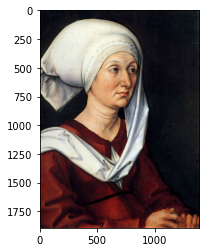

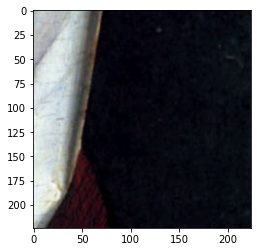

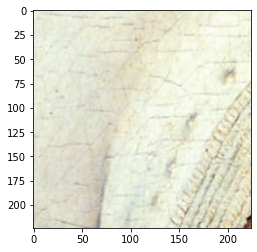

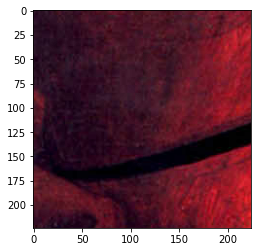

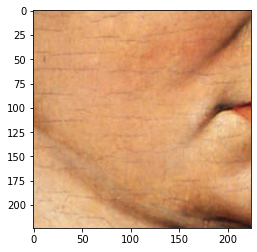

In [258]:
#Try Image Cropper for one painting
img_path = 'data_small/train/Albrecht Durer/4401.jpg'
img = image.load_img(img_path)
x_img = image.img_to_array(img)

plt.figure(0)
imgplot = plt.imshow(img)

for i in range(1,5):
    plt.figure(i)
    batch_x = random_crop(x_img, (224, 224))
    imgplot = plt.imshow(image.array_to_img(batch_x))
plt.show()

### 4) Data Preprocessing and Augmentation
We will use generators to flip, center/normalize per sample, and crop images. Our generator shall generate batches for the training of the neural network. We will adjust batch size based on the total number of training/testing samples. Note that the generators return tuple (batch_x, batch_y). batch_x contains batch of images. batch_y contains batches of output labels which are 1-hot encoding vectors. Thus we can feed into Neural network fit function for training

The file 81823.jpg, from artist Pierre-Auguste Renoir was corrupted, and had extremely large amount of pixels. Recurisvely walk through directory to find these corrupt files. The Image.open() will return an error for having too many pixels. Catch this error.

In [ ]:
from PIL import Image

for root, directories, filenames in os.walk(base_dir):
    for filename in filenames:
        file_name = os.path.join(root, filename)
        print(file_name)
        try:
            img = Image.open(file_name)
            #print(img.size)
            img.close()
        except:
            print('error file is corrupted, too many pixels: ', file_name)

Count the total training and testing sizes, so we know how many steps per epoch for fitting neural network. The model.fit_generator doesn't know how many files in training/test folder, it just iteratively outputs batches of specified size. Need to make steps_per_epoch = floor(total_files / batch_size)

In [305]:
train_artist_counts = {}
test_artist_counts = {}
train_size = 0
test_size = 0

for artist in chosen_artists:
    train_artist_counts[artist] = len(os.listdir(os.path.join(train_dir, artist)));
    test_artist_counts[artist] = len(os.listdir(os.path.join(test_dir, artist)))
    print('total training images for',artist, 'is: ', train_artist_counts[artist])
    print('total testing images for',artist, 'is: ', test_artist_counts[artist])
    train_size += train_artist_counts[artist]
    test_size +=test_artist_counts[artist]

print('total training size', train_size)
print('total test size', test_size)

total training images for Pierre-Auguste Renoir is:  316
total testing images for Pierre-Auguste Renoir is:  71
total training images for Albrecht Durer is:  304
total testing images for Albrecht Durer is:  79
total training images for Marc Chagall is:  289
total testing images for Marc Chagall is:  78
total training images for Ivan Aivazovsky is:  296
total testing images for Ivan Aivazovsky is:  82
total training images for Rembrandt is:  298
total testing images for Rembrandt is:  78
total training size 1503
total test size 388


Create generators that randomly flip horizontally, center and normalizes images per sample, and crops them to 224x224 images.

In [325]:
#Make test/train directories
base_dir = 'data_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(horizontal_flip=True, samplewise_center=True, samplewise_std_normalization=True)
train_batches = train_datagen.flow_from_directory(train_dir, batch_size=30, class_mode='categorical')
train_crops = crop_generator(train_batches, 224)

#Do not randomly flip for test data
test_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
test_batches = test_datagen.flow_from_directory(test_dir, batch_size=30, class_mode='categorical')
test_crops = crop_generator(test_batches, 224)

Found 1503 images belonging to 5 classes.
Found 388 images belonging to 5 classes.


### 5) Train Convolutional Neural Network

#### Part I (Step 1): Pretrained ResNet50 (freezed ResNet, unfreezed softmax)

In [80]:
import keras
from keras import applications
from keras import layers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import optimizers

In [317]:
def plot_accuracy(m_acc, m_val_acc):
    epochs = range(len(m_acc))
    maxim = max(m_val_acc)
    plt.figure()
    plt.plot(epochs, m_acc, 'bo', label='Training acc')
    plt.plot(epochs, m_val_acc, 'ro', label='Validation acc')
    string = "Training and validation accuracy + (max validation accuracy={})".format(maxim)
    plt.title(string)
    plt.legend()
    plt.show()
    
def plot_losses(train_loss, val_loss):
    epochs = range(len(train_loss))
    minum = min(val_loss)
    plt.figure()
    plt.plot(epochs, train_loss, 'bo', label='Training acc')
    plt.plot(epochs, val_loss, 'ro', label='Validation acc')
    string = "Training and validation loss (min validation loss={})".format(minum)
    plt.title(string)
    plt.legend()
    plt.show()

In [263]:
#Load pretrained ResNet50 neural network, and remove final classification layer
resnet = applications.resnet50.ResNet50(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

c:\extra stuff\software - installations\python374\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Use a keras functional  model (rather than sequential) to attach output of loaded ResNet50 model to GlobalAveragePooling and Dense layers. Keras functional model can have multiple inputs and outputs, as well as shared layers. Can piece together chunks of network anyway desired, rather than just sequentially adding layers. In this case, we only have 1 input and 1 output.

In [264]:
#Attach GloablAveragePooling2D and softmax Dense layer for classification of our chosen artists.
x = resnet.output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.7)(x)
output_layer = Dense(len(chosen_artists), activation = 'softmax')(x)
model = Model(inputs = resnet.input, outputs = output_layer)

We will freeze all layers, except for our final classification layer. This way, for initial training iterations, we do not change weights of ResNet

In [266]:
num_layers_freeze = len(model.layers)-1

for layer in model.layers[:num_layers_freeze]:
    layer.trainable = False
for layer in model.layers[num_layers_freeze:]:
    layer.trainable = True

In [267]:
model.compile(optimizer=optimizers.adam(lr=0.001, beta_1=.9, beta_2=.999),
             loss='categorical_crossentropy', metrics=['accuracy'])
model.save_weights('model_weights_p1_init.h5')

In [265]:
print('Show the final three layers:')
print('Third to last layer is', model.layers[len(model.layers)-3])
print('Second to last layer is', model.layers[len(model.layers)-2])
print('Last layer is', model.layers[len(model.layers)-1])

Show the final three layers:
Third to last layer is <keras.layers.core.Activation object at 0x0000014629770F88>
Second to last layer is <keras.layers.pooling.GlobalAveragePooling2D object at 0x00000146253B9148>
Last layer is <keras.layers.core.Dense object at 0x00000146253B9588>


Train Neural Network for a couple epochs, with frozen ResNet layers. <br>
- The steps_per_epoch is determined by floor(num_samples/batch_size). <br>
- Training: 50=floor(1503/30), Testing: 12=floor(388/30). <br>
- Use adam optimizer with learning_rate=.001, beta_1=.9, beta_2=.999)

In [313]:
model.load_weights('model_weights_p1_init.h5')
history_p1_s1 = model.fit_generator(train_crops,
                        steps_per_epoch = np.floor(train_batches.samples/30).astype(int),
                        epochs = 2,
                        validation_data = test_crops,
                        validation_steps = np.floor(test_batches.samples/30).astype(int))

model.save_weights('model_weights_p1_s1.h5')

Epoch 1/2
50/50 [==============================] - 402s 8s/step - loss: 0.8169 - accuracy: 0.6973 - val_loss: 2.3406 - val_accuracy: 0.2944
Epoch 2/2
50/50 [==============================] - 392s 8s/step - loss: 0.4057 - accuracy: 0.8663 - val_loss: 2.5254 - val_accuracy: 0.2346


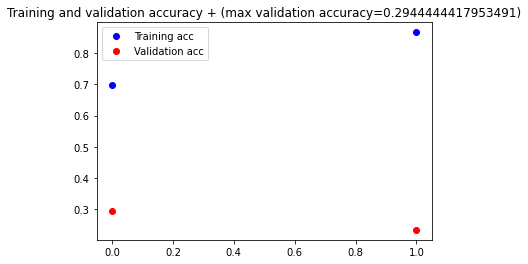

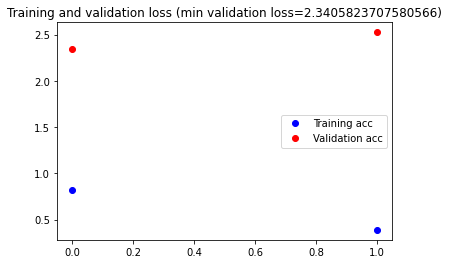

In [318]:
plot_accuracy(history_p1_s1.history['accuracy'], history_p1_s1.history['val_accuracy'])
plot_losses(history_p1_s1.history['loss'], history_p1_s1.history['val_loss'])

#### Part I (Step 2): Pretrained ResNet50 (unfreezed ResNet layers, unfreezed Softmax layers)

In [326]:
model.load_weights('model_weights_p1_s1.h5')

num_layers_freeze = len(model.layers)-1

for layer in model.layers[:num_layers_freeze]:
    layer.trainable = True
for layer in model.layers[num_layers_freeze:]:
    layer.trainable = True

model.compile(optimizer=optimizers.adam(lr=0.0001, beta_1=.9, beta_2=.999),
         loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_p1_s2 = model.fit_generator(train_crops,
                        steps_per_epoch = 50,
                        epochs = 4,
                        validation_data = test_crops,
                        validation_steps = 30)
model.save_weights('model_weights_p1_s2.h5')

Epoch 1/4
20/50 [===========>..................] - ETA: 17:04 - loss: 0.3023 - accuracy: 0.8933

In [ ]:
plot_accuracy(history_p1_s2.history['accuracy'], history_p1_s2.history['val_accuracy'])
plot_losses(history_p1_s2.history['loss'], history_p1_s2.history['val_loss'])

In [ ]:
#Extracts first layer (conv2d_5, conv2d_6, conv2d_7, max_pooling2d_5)
layer_outputs = [model.layers[0].output, model.layers[1].output, model.layers[len(model.layers)-3].output, model.layers[len(model.layers)-2].output]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)